# Graph My Task Statistics

We'll use the matplotlib [Stacked Area Plot](https://www.python-graph-gallery.com/stacked-area-plot/) to visualize the accumulation of incoming vs. completed tasks over time.

In [13]:
%matplotlib widget

import math
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import mplcursors

from main import AmazingCloudAntClient

client = AmazingCloudAntClient()
chart_data = client.get_task_stats_for_chart()

date_fmt = DateFormatter("%Y-%m-%d")

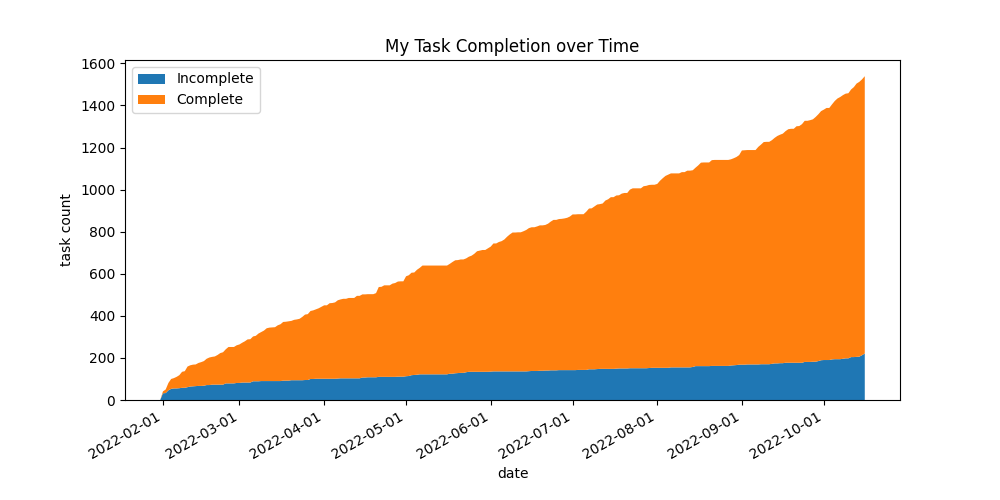

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Set up figure
ax.stackplot(
    chart_data["dates"],
    chart_data["incomplete"],
    chart_data["complete"],
    labels=['Incomplete','Complete'],
)
plt.legend(loc='upper left')
plt.title("My Task Completion over Time")
plt.xlabel('date')
plt.ylabel('task count')

# Format Dates
fig.autofmt_xdate()
ax.xaxis.set_major_formatter(date_fmt)

mplcursors.cursor(hover=True)
# plt.show()

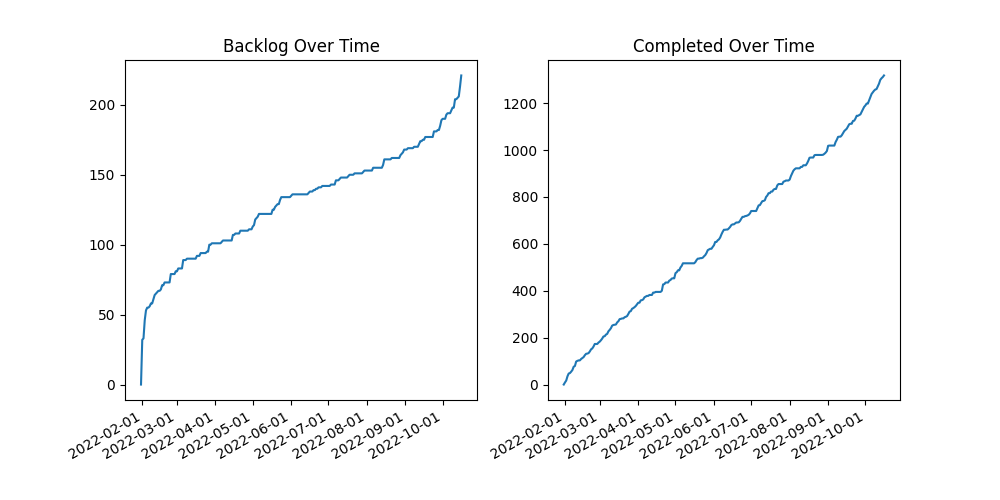

In [15]:
# Set up figures
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
ax1.title.set_text("Backlog Over Time")
ax2.title.set_text("Completed Over Time")
ax1.plot_date(chart_data["dates"], chart_data["incomplete"], "-")
ax2.plot_date(chart_data["dates"], chart_data["complete"], "-")

# Format dates
fig.autofmt_xdate()
date_form = DateFormatter("%Y-%m-%d")
ax1.xaxis.set_major_formatter(date_form)
ax2.xaxis.set_major_formatter(date_form)

mplcursors.cursor(hover=True)
# plt.show()

In [16]:
# Tasks Added / Removed Today
today_stats = client.get_tasks_added_removed_between()

print("TODAY'S TASK STATS")

print(f'{ len(today_stats["created"]) } Task/s Created')
for t in today_stats["created"]:
    print(f'  - { t["doc"]["title"] }')

print('')

print(f'{ len(today_stats["completed"]) } Task/s Completed')
for t in today_stats["completed"]:
    print(f'  - { t["doc"]["title"] }')

TODAY'S TASK STATS
13 Task/s Created
  - Promly: follow up on email thread after deploy
  - Ensure all active apps are upgraded past the Heroku-18 stack[Slack Msg from Ed](https://thinknimble.slack.com/archives/C02LK1X84N7/p1666036593822529)
  - Bootstrapper
  - Squirrel: Prep some language to share with teachers about how to communicate about issues (ex: bug reports should include device type, list of actions taken, etc.).
  - Squirrel: Work with James to update from .org to .co domain
  - Squirrel: Add an action to Run/Pause the game at the school level
  - Respond to [Slack Msg from Ed](https://thinknimble.slack.com/archives/C044169VCF7/p1666029682472729)
  - Check on on Jennifer Growth Plan (and create new task for Nov 30)
  - Create a repo and begin outlining
  - Brainstorm topics
  - Squirrel: Pausing the game: we need to change it so that life events are not created when the game is paused.
  - Promly: Tell Pari we should set up an [App Store Connect API Key (I ended up using Sp

NOTE: Negative cycle times are recurring tasks that were marked 'done' before the date of recurrence.

Q1: 0.36309828703703706
Q3: 4.507865451388889
IQR: 4.144767164351852
outer_fence: 16.942166944444445
95th: 29.476685365740707
99th: 129.35414369398143

113 outliers: [17.25333009259259, 17.352951990740742, 17.716218009259258] ... [224.55683181712962, 226.71895820601853, 234.53673059027778]


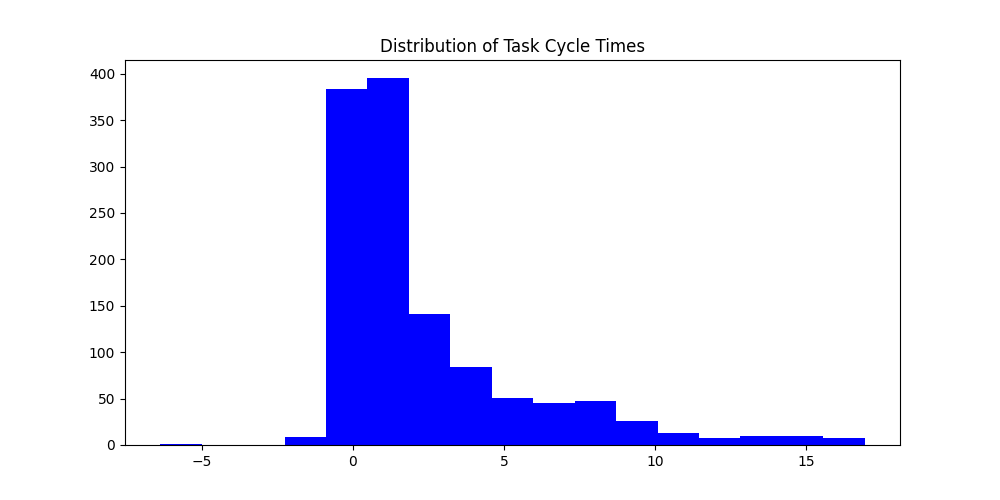

In [17]:
# Look at distribution of task cycle times
tasks = client.get_all_tasks()
cycle_times = sorted([t.cycle_time for t in tasks if t.done])

q1, q3, n5, n9 = np.percentile(cycle_times, [25, 75, 95, 99])
iqr = q3 - q1
outer_fence = q3 + 3*(iqr)

print("NOTE: Negative cycle times are recurring tasks that were marked 'done' before the date of recurrence.")

print(f"""
Q1: {q1}
Q3: {q3}
IQR: {iqr}
outer_fence: {outer_fence}
95th: {n5}
99th: {n9}
""")

outliers = sorted([c for c in cycle_times if c >= outer_fence])
print(f"{len(outliers)} outliers: {outliers[:3]} ... {outliers[-3:]}")

# Filter out outliers
a = [i for i in cycle_times if i not in outliers]

# Plot it
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(a, bins=math.ceil(max(a)), histtype ='bar', facecolor='blue')
ax.title.set_text("Distribution of Task Cycle Times")


NOTE: Negative cycle times are recurring tasks that were marked 'done' before the date of recurrence.

Q1: 1.8453086689814815
Q3: 8.766910972222222
IQR: 6.921602303240741
outer_fence: 29.531717881944445
95th: 54.369620810184976
99th: 146.12485048148133



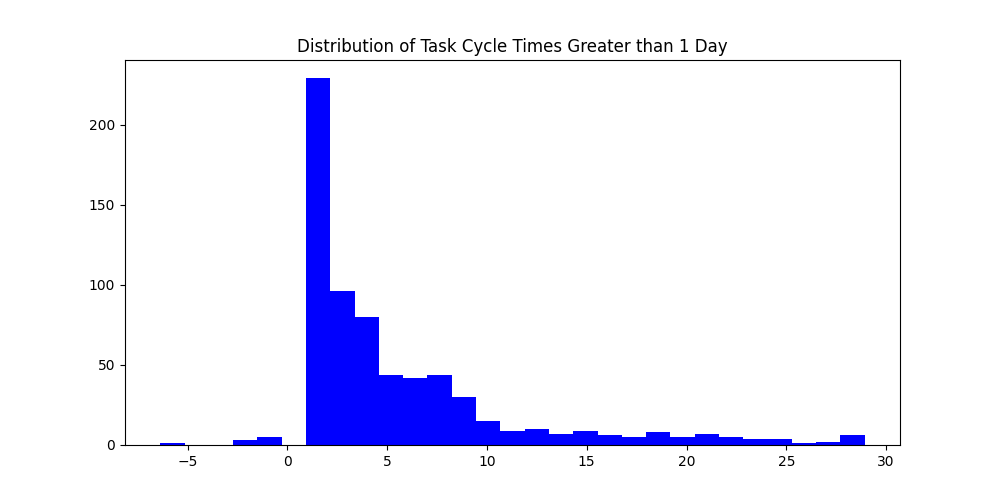

In [18]:
# CYCLE TIMES EXCLUDING SAME-DAY TASKS
gt_1_day_cycle_times = sorted([t.cycle_time for t in tasks if t.done and (t.cycle_time < -1 or t.cycle_time > 1)])

q1, q3, n5, n9 = np.percentile(gt_1_day_cycle_times, [25, 75, 95, 99])
iqr = q3 - q1
outer_fence = q3 + 3*(iqr)

print("NOTE: Negative cycle times are recurring tasks that were marked 'done' before the date of recurrence.")

print(f"""
Q1: {q1}
Q3: {q3}
IQR: {iqr}
outer_fence: {outer_fence}
95th: {n5}
99th: {n9}
""")

outliers = sorted([c for c in gt_1_day_cycle_times if c >= outer_fence])
print(f"{len(outliers)} outliers: {outliers[:3]} ... {outliers[-3:]}")

# Filter outliers & Plot it
b = [i for i in gt_1_day_cycle_times if i not in outliers]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(b, bins=math.ceil(max(b)), histtype ='bar', facecolor='blue')
ax.title.set_text("Distribution of Task Cycle Times Greater than 1 Day")
mplcursors.cursor(hover=True)